In [1]:
import geopandas as gpd
import pandas as pd
import sys
import os

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch

num_of_gpus = torch.cuda.device_count()
print(num_of_gpus)

1


In [3]:
from tqdm import tqdm_notebook

In [4]:
from scipy.spatial.distance import pdist

In [5]:
nycnodes = os.path.join("data","new-york","nodes.geojson")
nodes = gpd.read_file(nycnodes)

In [6]:
# node_points = np.array([nodes.geometry.x, nodes.geometry.y]).T

In [7]:
# node_points

In [8]:
# distances = pdist(node_points)

In [9]:
# plt.hist(distances, bins=500, color="black")

# plt.title("Histogram of Distances between Images")
# plt.xlabel("Meters")
# plt.ylabel("Count")
# plt.show()

In [10]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [11]:
from src.neighbor_identification import neighbors

In [12]:
import networkx as nx

In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
np.arange(0,10,2)

array([0, 2, 4, 6, 8])

In [15]:
neighbor_radius = 100
building_buffer = 400

In [16]:
config = {
    "random_seed": 1,
    "custom_optimizer": torch.optim.Adam,
    "lr" : 0.05,
    'epochs': 500,
    'linear_layers': 2,
    'hidden_channels': 8,
    'dropout': 0.1,
    'test_percent': 15,
    'building_buffer': 400,
    'building_buffer_min':20,
    'building_buffer_max':500,
    'building_buffer_npoints':100,
    'neighbor_radius': 100,
    'n_cv': 8,
    'n_cv_generalization':12,
    'cv_size': 1500,
    'graph_outchannels': 8,
    'graph_layers':1,
    'graph_heads':1,
    'partition_terms': [
        "road_area",
        "building_area",
        "sky_area",
        "vegetation_area",
        # "car_count",
        # "person_count"
    ]
}

In [17]:
from src.graph_construction import graph
nycgraph, rebuild_info = graph("new-york", **config)
# g1p = pool_adjacency(g1, g1a)

In [18]:
nycgraph

HeteroData(
  pano={ x=[106436, 4] },
  footprint={
    x=[13872, 3],
    y=[13872],
    train_mask=[13872],
    test_mask=[13872]
  },
  (footprint, contains, pano)={ edge_index=[2, 6968936] },
  (pano, links, pano)={ edge_index=[2, 4287142] },
  (pano, rev_contains, footprint)={ edge_index=[2, 6968936] }
)

In [24]:
def lcc_vis(node_data, radius_list = np.arange(0,200,5)):
    connected_components = []

    for radius in tqdm_notebook(radius_list):
        edge_list = neighbors(
            node_data,
            radius = radius
        )
        G = nx.from_edgelist(edge_list.detach().cpu().numpy().T)
        G.remove_nodes_from(list(nx.isolates(G)))
        graph_components = list(nx.connected_components(G))
        connected_components.append(len(graph_components))

#     plt.step(
#         radius_list[1:],
#         connected_components[1:],
#         color="black"
#     )

    return radius_list[1:], connected_components[1:]

In [20]:
austingraph, austin_rebuild_info = graph("austin", **config)

In [21]:
sfgraph, sf_rebuild_info = graph("san-francisco", **config)

In [22]:
sfgraph

HeteroData(
  pano={ x=[22562, 4] },
  footprint={
    x=[1491, 3],
    y=[1491],
    train_mask=[1491],
    test_mask=[1491]
  },
  (footprint, contains, pano)={ edge_index=[2, 333621] },
  (pano, links, pano)={ edge_index=[2, 1674060] },
  (pano, rev_contains, footprint)={ edge_index=[2, 333621] }
)

In [25]:
sX, sY = lcc_vis(sf_rebuild_info['node_data_original'])

/tmp/ipykernel_430944/4189049934.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for radius in tqdm_notebook(radius_list):


  0%|          | 0/40 [00:00<?, ?it/s]

In [26]:
aX, aY = lcc_vis(austin_rebuild_info['node_data_original'])

/tmp/ipykernel_430944/4189049934.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for radius in tqdm_notebook(radius_list):


  0%|          | 0/40 [00:00<?, ?it/s]

In [27]:
nX, nY = lcc_vis(rebuild_info['node_data_original'])

/tmp/ipykernel_430944/4189049934.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for radius in tqdm_notebook(radius_list):


  0%|          | 0/40 [00:00<?, ?it/s]

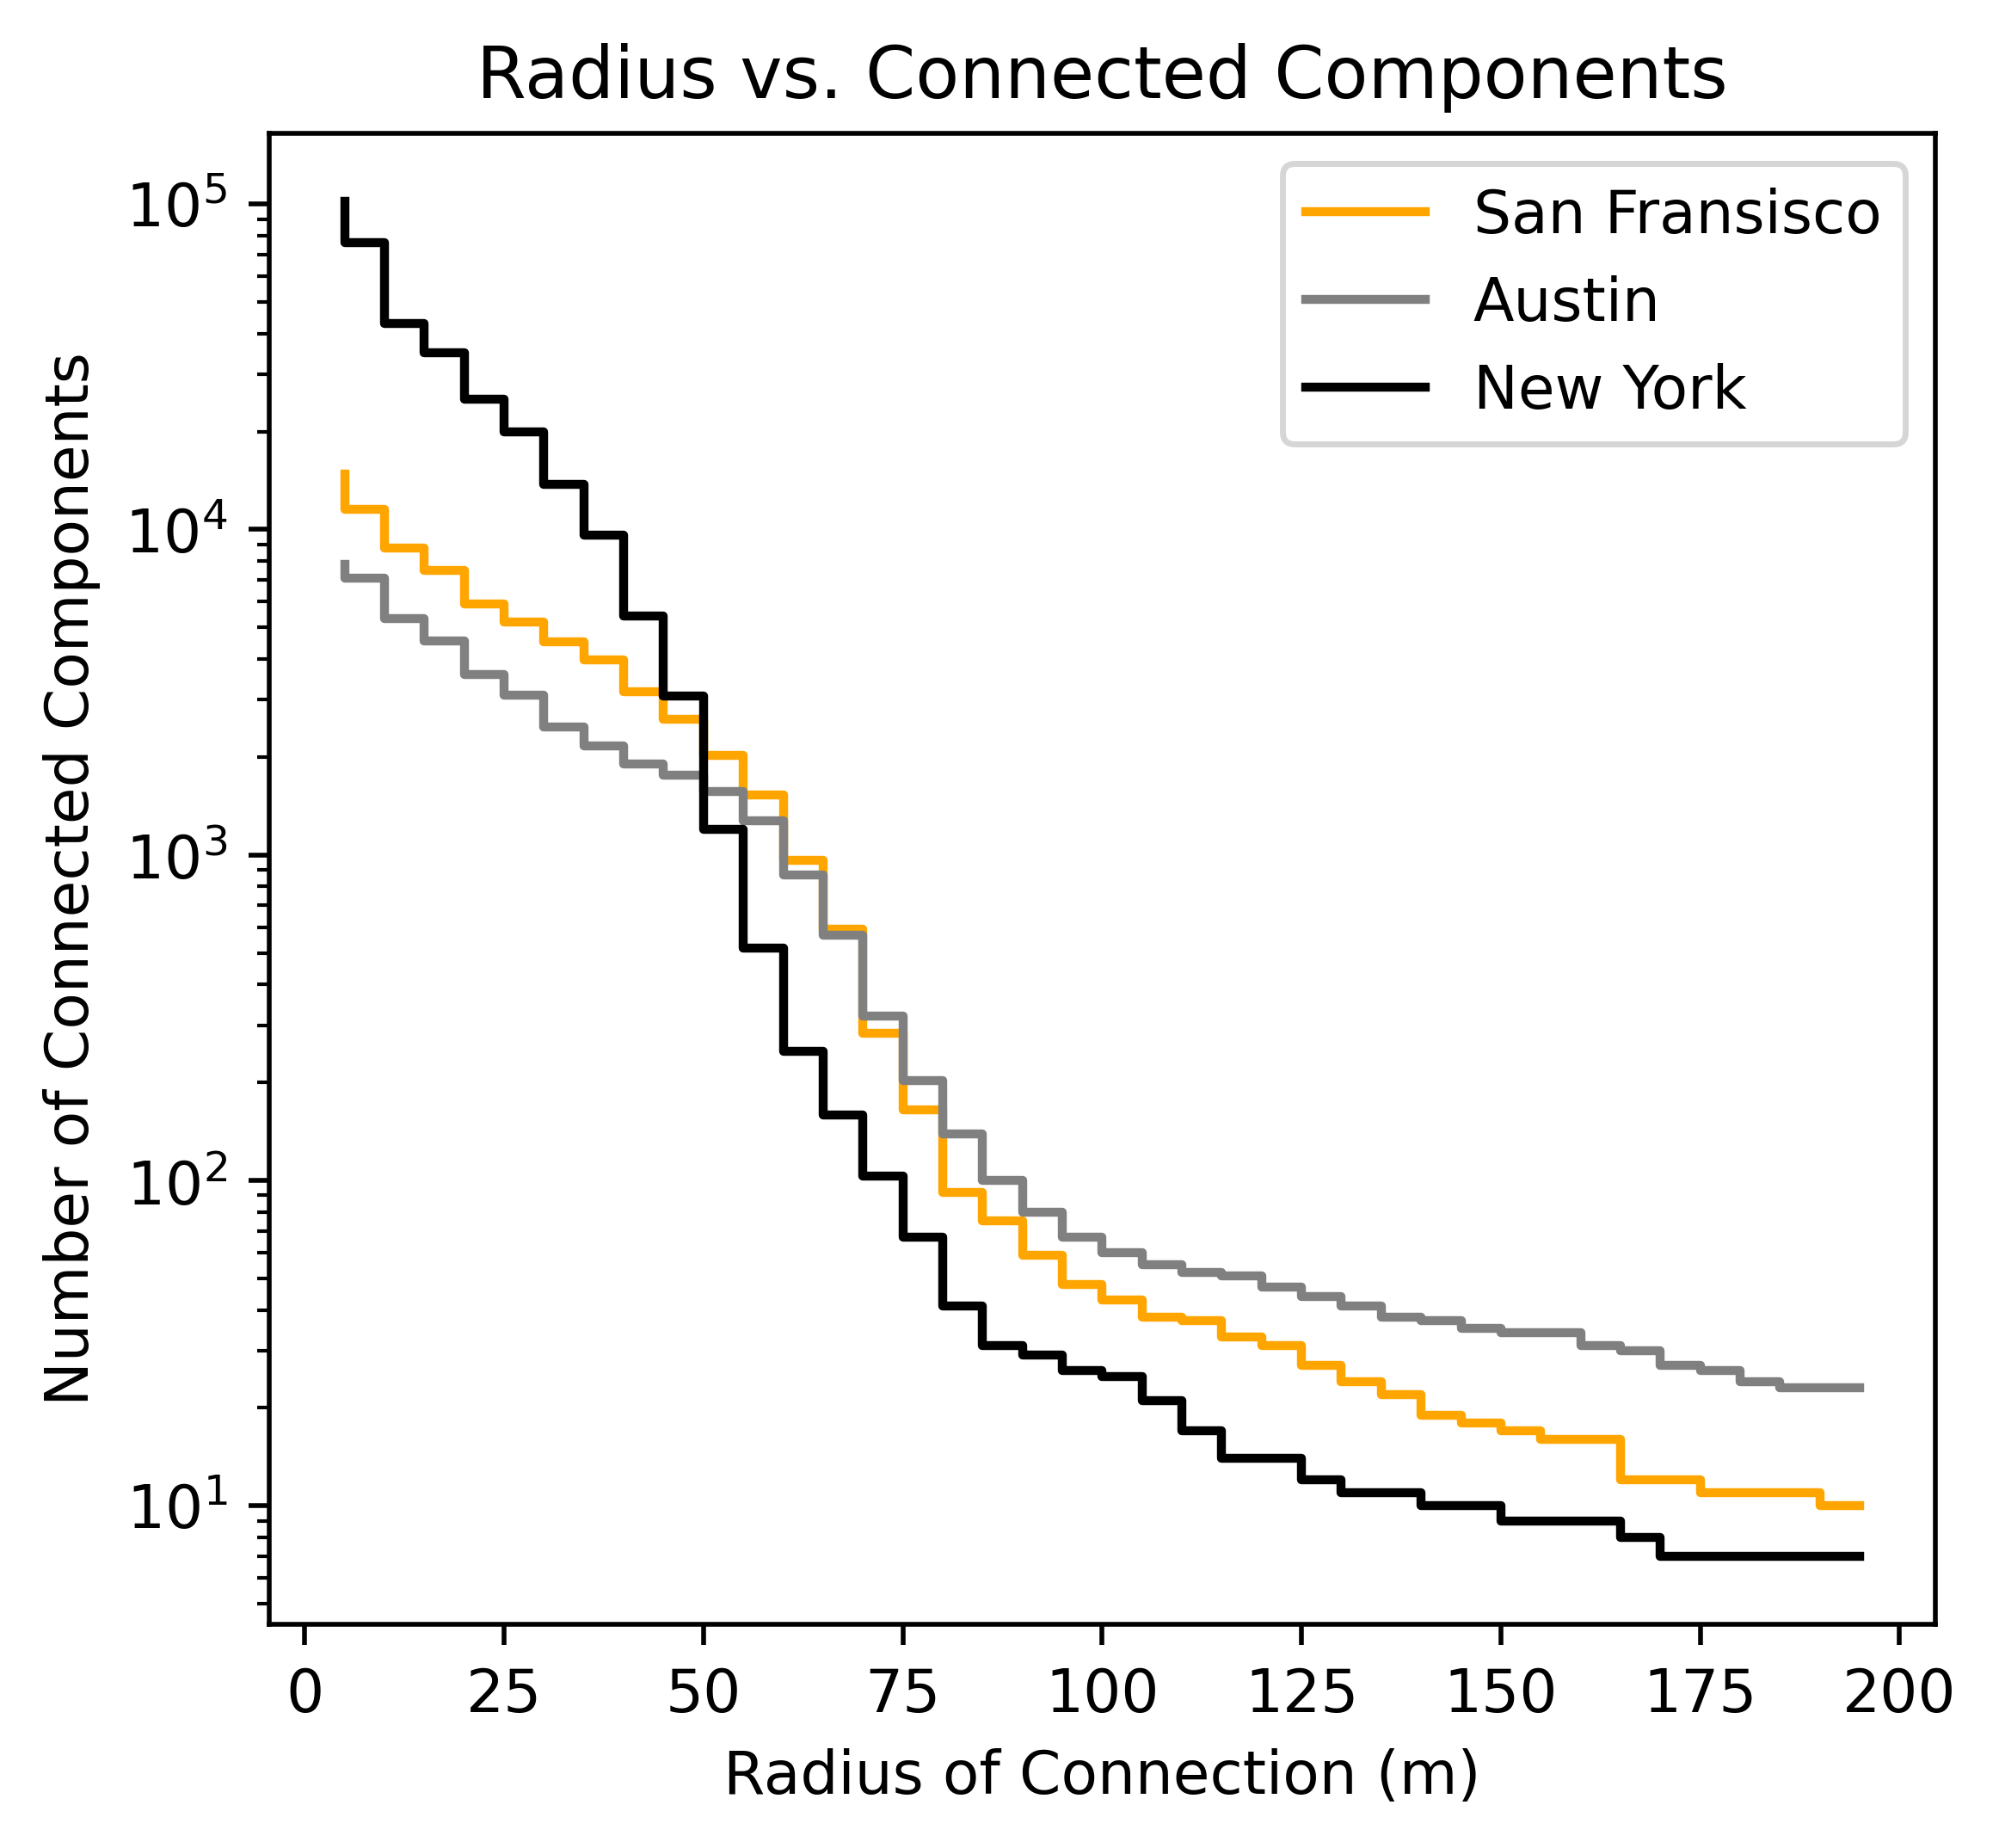

In [51]:
# Plotting both the curves simultaneounode_data_original= 
fig, ax = plt.subplots(figsize=(5,4.5), dpi=500)

ax.step(sX, sY, color="orange", label="San Fransisco")
ax.step(aX, aY, color='gray', label='Austin')
ax.step(nX, nY, color='black', label='New York')
  
plt.yscale("log")

plt.xlabel("Radius of Connection (m)")
plt.ylabel("Number of Connected Components")
plt.title("Radius vs. Connected Components")

plt.legend()
plt.savefig("connected-component-history.png")

plt.show()

KeyboardInterrupt: 

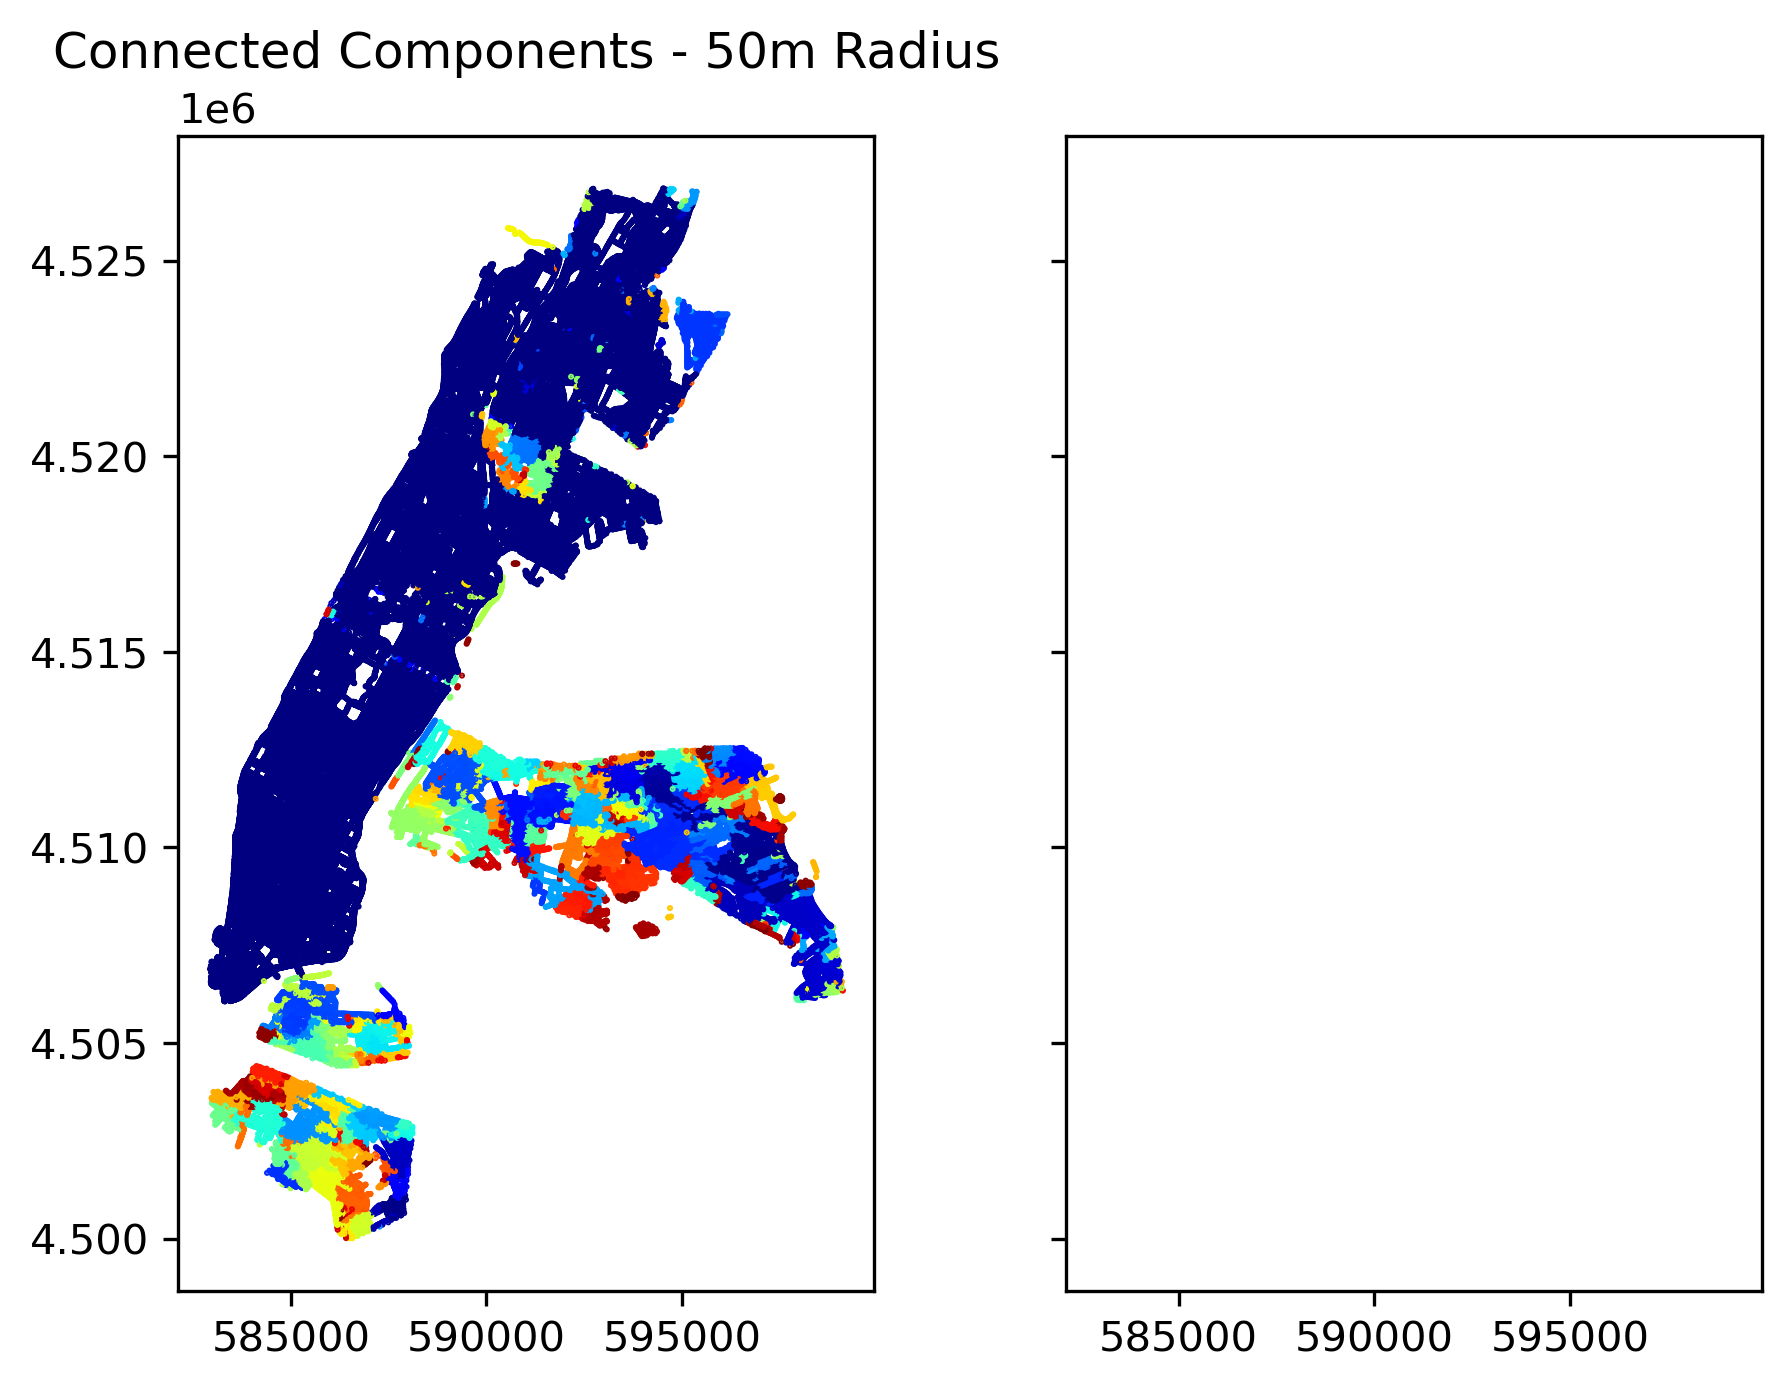

In [49]:
import copy
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar

color_thing = plt.cm.jet

fig, (ax1, ax2) = plt.subplots(
    1, 2, 
    sharex=True, 
    sharey=True, 
    figsize=(7, 5),
    dpi=300
)
plt.locator_params(axis='x', nbins=4)

### section 1 - showing the connected components of 10 meter radius
test_radius = 50
edge_list = neighbors(
    rebuild_info['node_data_original'],
    radius = test_radius
)
G = nx.from_edgelist(edge_list.detach().cpu().numpy().T)
graph_components = list(nx.connected_components(G))

color_arr = np.repeat(["#FF0000"], len(rebuild_info['node_data_original']))

for c,component in enumerate(graph_components):
    cterm = c / len(graph_components)
    color_arr[np.array(list(component))] = matplotlib.colors.to_hex(
        color_thing(cterm), 
        keep_alpha=True
    )
    
nodedata = rebuild_info['node_data_original']
nodedata.plot(markersize=0.2, ax=ax1, color=color_arr)
ax1.set_title(f"Connected Components - {test_radius}m Radius")

### section 2 - showing the connected components of larger radius
test_radius = 100
edge_list = neighbors(
    rebuild_info['node_data_original'],
    radius = test_radius
)
G = nx.from_edgelist(edge_list.detach().cpu().numpy().T)
graph_components = list(nx.connected_components(G))

color_arr = np.repeat(["#FF0000"], len(rebuild_info['node_data_original']))

for c,component in enumerate(graph_components):
    cterm = c / len(graph_components)
    color_arr[np.array(list(component))] = matplotlib.colors.to_hex(
        color_thing(cterm), 
        keep_alpha=True
    )
    
nodedata.plot(markersize=0.2, ax=ax2, color=color_arr)
ax2.set_title(f"Connected Components - {test_radius}m Radius")

ax1.add_artist(ScaleBar(1))
ax2.add_artist(ScaleBar(1))

plt.tight_layout()

plt.savefig('nyc_components.png')
plt.show()

In [30]:
G = nx.from_edgelist(nycgraph['pano','links','pano']['edge_index'].detach().cpu().numpy().T)
G.remove_nodes_from(list(nx.isolates(G)))

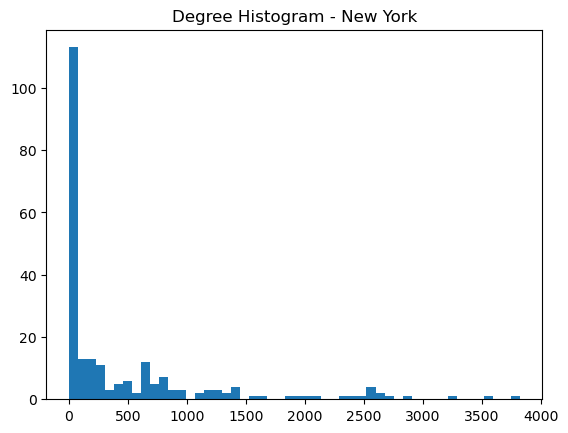

In [31]:
plt.hist(nx.degree_histogram(G), bins=50)

plt.title("Degree Histogram - New York")
plt.show()

In [32]:
def graph_statistics(graphobject, graphname):
    G = nx.from_edgelist(graphobject['pano','links','pano']['edge_index'].detach().cpu().numpy().T)
#     G.remove_nodes_from(list(nx.isolates(G)))
    
    return {
        "Density": nx.density(G),
        "Edges": nx.number_of_edges(G),
        "Nodes": nx.number_of_nodes(G),
        "Assortivity": nx.degree_assortativity_coefficient(G),
        "Transitivity": nx.transitivity(G)
        # "Omega": nx.omega(G)
    }

In [33]:
nyc_nxgraph = nx.from_edgelist(nycgraph['pano','links','pano']['edge_index'].detach().cpu().numpy().T)

In [34]:
## also to compare a bit against a random, er graph with the same number of edges and nodes as nyc
total_possible_edges = (nx.number_of_nodes(nyc_nxgraph) * ((nx.number_of_nodes(nyc_nxgraph) - 1))) / 2
edge_probability = nx.number_of_edges(nyc_nxgraph) / total_possible_edges

random_graph = nx.erdos_renyi_graph(nycgraph.num_nodes, edge_probability)

In [35]:
nx.number_of_nodes(random_graph)

120308

In [36]:
nycgraph.num_nodes

120308

In [37]:
randomstats = {
    "Density": nx.density(random_graph), 
    "Edges": nx.number_of_edges(random_graph),
    "Nodes": nx.number_of_nodes(random_graph),
    "Assortivity": nx.degree_assortativity_coefficient(random_graph),
    "Transitivity": nx.transitivity(random_graph),
    # "Omega": nx.omega(random_graph)
}
randomstats

{'Density': 0.00038783189819999127,
 'Edges': 2806719,
 'Nodes': 120308,
 'Assortivity': 0.0006709338778228464,
 'Transitivity': 0.0003865922997515189}

In [38]:
nystats = graph_statistics(nycgraph, "New York")
nystats

{'Density': 0.00038783351074963337,
 'Edges': 2196789,
 'Nodes': 106436,
 'Assortivity': 0.9361426151400348,
 'Transitivity': 0.6455842851720128}

In [39]:
sfstats = graph_statistics(sfgraph, "San Fransisco")
sfstats

{'Density': 0.003333106217747493,
 'Edges': 848311,
 'Nodes': 22562,
 'Assortivity': 0.917536066935662,
 'Transitivity': 0.7435365117964859}

In [40]:
austats = graph_statistics(austingraph, "Austin")
austats

{'Density': 0.001968625094663637,
 'Edges': 60324,
 'Nodes': 7829,
 'Assortivity': 0.8387408044832139,
 'Transitivity': 0.6184377716846118}

In [41]:
statsdf = pd.DataFrame([randomstats, nystats, sfstats, austats], index=['Erdős–Rényi','New York','San Fransisco','Austin'])

In [47]:
statsdf

,Density,Edges,Nodes,Assortivity,Transitivity
Erdős–Rényi,0.000388,2806719,120308,0.000671,0.000387
New York,0.000388,2196789,106436,0.936143,0.645584
San Fransisco,0.003333,848311,22562,0.917536,0.743537
Austin,0.001969,60324,7829,0.838741,0.618438


In [48]:
with pd.option_context('display.float_format', '{:,.4f}'.format):
   print(statsdf.to_latex(index=True))

\begin{tabular}{lrrrrr}
\toprule
{} &  Density &    Edges &   Nodes &  Assortivity &  Transitivity \\
\midrule
Erdős–Rényi   &   0.0004 &  2806719 &  120308 &       0.0007 &        0.0004 \\
New York      &   0.0004 &  2196789 &  106436 &       0.9361 &        0.6456 \\
San Fransisco &   0.0033 &   848311 &   22562 &       0.9175 &        0.7435 \\
Austin        &   0.0020 &    60324 &    7829 &       0.8387 &        0.6184 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_430944/875685880.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(statsdf.to_latex(index=True))


In [43]:
print(statsdf.to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 Density &   Edges &  Nodes &  Assortivity &  Transitivity \\
\midrule
0.000388 & 2806719 & 120308 &     0.000671 &      0.000387 \\
0.000388 & 2196789 & 106436 &     0.936143 &      0.645584 \\
0.003333 &  848311 &  22562 &     0.917536 &      0.743537 \\
0.001969 &   60324 &   7829 &     0.838741 &      0.618438 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_430944/1775357909.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(statsdf.to_latex(index=False))
